## Device configuration

In [1]:
from tinygrad import Device

print(Device.DEFAULT)

METAL


## Model

In [2]:
from tinygrad import Tensor, nn

class Model:
  def __init__(self):
    self.l1 = nn.Conv2d(1, 32, kernel_size=(3,3))
    self.l2 = nn.Conv2d(32, 64, kernel_size=(3,3))
    self.l3 = nn.Linear(1600, 10)

  def __call__(self, x:Tensor) -> Tensor:
    x = self.l1(x).relu().max_pool2d((2,2))
    x = self.l2(x).relu().max_pool2d((2,2))
    return self.l3(x.flatten(1).dropout(0.5))

## Get the MNIST dataset

In [3]:
from tinygrad.nn.datasets import mnist

X_train, Y_train, X_test, Y_test = mnist()
# Use only a third of the training dataset
# X_train = X_train[:len(X_train)//3]
# Y_train = Y_train[:len(Y_train)//3]
print(X_train.shape, X_train.dtype, Y_train.shape, Y_train.dtype)

(60000, 1, 28, 28) dtypes.uchar (60000,) dtypes.uchar


## Use the model

In [4]:
model = Model()
acc = (model(X_test).argmax(axis=1) == Y_test).mean()
print(acc.item())  

0.0949999988079071


### Train the model

In [5]:
optim = nn.optim.Adam(nn.state.get_parameters(model))
batch_size = 128
def training_step():
    Tensor.training = True  # makes dropout work
    samples = Tensor.randint(batch_size, high=X_train.shape[0])
    X, Y = X_train[samples], Y_train[samples]
    optim.zero_grad()
    loss = model(X).sparse_categorical_crossentropy(Y).backward()
    optim.step()
    return loss

In [6]:
# import timeit
# execution_times_5ts = [t * 1000 for t in timeit.repeat(training_step, repeat=5, number=1)]
# average_time_ts = sum(execution_times_5ts) / len(execution_times_5ts)
# print(f"Average execution time: {average_time_ts:.2f} ms")

In [7]:
from tinygrad import TinyJit

jit_step = TinyJit(training_step)

In [8]:
# import timeit
# execution_times_5js = [t * 1000 for t in timeit.repeat(jit_step, repeat=5, number=1)]
# average_time_js = sum(execution_times_5js) / len(execution_times_5js)
# print(f"Average execution time: {average_time_js:.2f} ms")

In [9]:
train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

for step in range(7000):
    # Calculate train loss
    loss = jit_step()
    train_losses.append(loss.item())

    if step%100 == 0:
        Tensor.training = False     # Disables dropout for evaluation

        # Calculate train accuracy
        # train_outputs = model(X_train)
        # train_acc = (train_outputs.argmax(axis=1) == Y_train).mean().item()
        # train_accuracies.append(train_acc)

        # Calculate test accuracy
        test_outputs = model(X_test)
        test_acc = (test_outputs.argmax(axis=1) == Y_test).mean().item()
        test_accuracies.append(test_acc)

        # Calculate test loss
        test_loss = test_outputs.sparse_categorical_crossentropy(Y_test).mean().item()
        test_losses.append(test_loss)

        # print(f"step {step:4d}, loss {loss.item():.2f}, train acc {train_acc*100.:.2f}%, test acc {test_acc*100.:.2f}%")
        print(f"step {step:4d}, loss {loss.item():.2f}, test acc {test_acc*100.:.2f}%")

step    0, loss 35.36, test acc 11.07%
step  100, loss 0.34, test acc 95.17%
step  200, loss 0.29, test acc 96.42%
step  300, loss 0.20, test acc 97.21%
step  400, loss 0.15, test acc 97.52%
step  500, loss 0.16, test acc 97.40%
step  600, loss 0.21, test acc 97.50%
step  700, loss 0.13, test acc 97.81%
step  800, loss 0.20, test acc 97.87%
step  900, loss 0.10, test acc 97.92%
step 1000, loss 0.19, test acc 97.92%
step 1100, loss 0.15, test acc 98.03%
step 1200, loss 0.05, test acc 98.06%
step 1300, loss 0.05, test acc 98.03%
step 1400, loss 0.25, test acc 98.03%
step 1500, loss 0.07, test acc 98.00%
step 1600, loss 0.11, test acc 98.21%
step 1700, loss 0.03, test acc 98.22%
step 1800, loss 0.18, test acc 98.20%
step 1900, loss 0.15, test acc 98.25%
step 2000, loss 0.09, test acc 98.43%
step 2100, loss 0.06, test acc 98.43%
step 2200, loss 0.06, test acc 98.17%
step 2300, loss 0.13, test acc 98.33%
step 2400, loss 0.06, test acc 98.55%
step 2500, loss 0.10, test acc 98.55%
step 2600, 

### Plot the loss

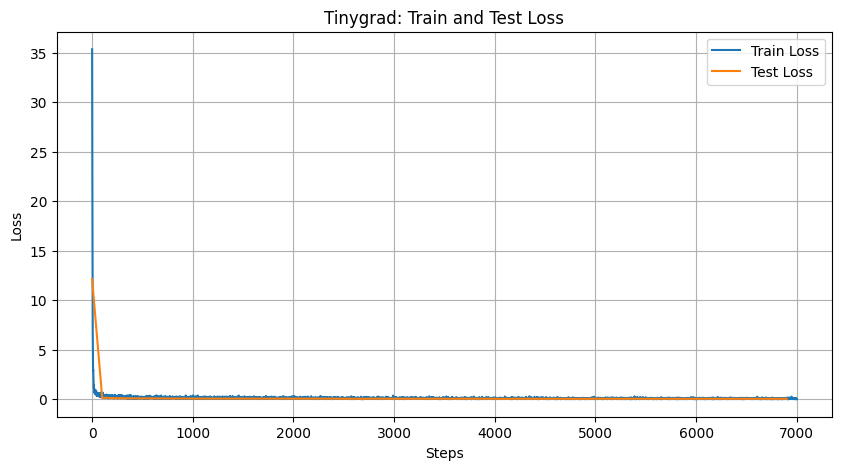

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(0, len(test_losses) * 100, 100), test_losses, label='Test Loss') # every 100 steps
plt.title('Tinygrad: Train and Test Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Plot the accuracy

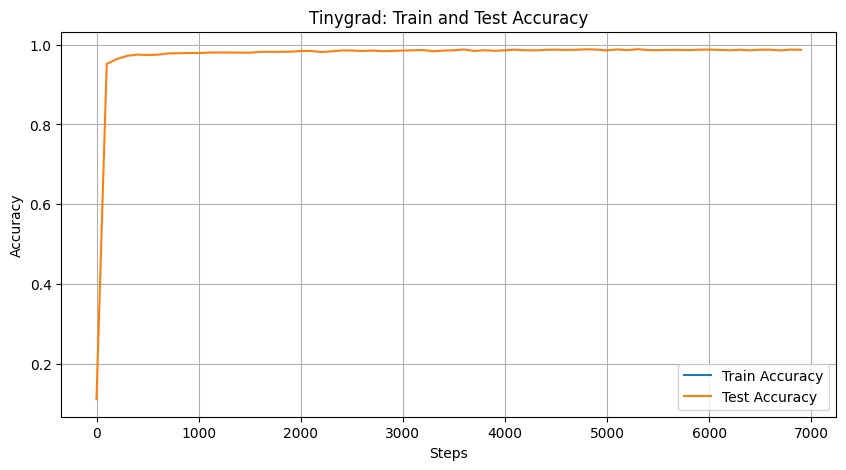

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, len(train_accuracies) * 100, 100), train_accuracies, label='Train Accuracy')
plt.plot(range(0, len(test_accuracies) * 100, 100), test_accuracies, label='Test Accuracy')
plt.title('Tinygrad: Train and Test Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Save the weights

In [12]:
import numpy as np

tinygrad_weights = {
    'l1.weight': model.l1.weight.numpy(),
    'l1.bias': model.l1.bias.numpy(),
    'l2.weight': model.l2.weight.numpy(),
    'l2.bias': model.l2.bias.numpy(),
    'l3.weight': model.l3.weight.numpy(),
    'l3.bias': model.l3.bias.numpy()
}
np.save('tinygrad_weights.npy', tinygrad_weights)

## Final probabilities

In [13]:
test_image = X_test[0:1]
tinygrad_probs = model(test_image).softmax().numpy()
print("tinygrad probabilities:", tinygrad_probs)

tinygrad probabilities: [[9.79151181e-14 1.03726665e-13 2.28489519e-10 5.26712441e-12
  7.12620079e-19 5.35970189e-17 9.85895792e-22 1.00000000e+00
  1.53749490e-13 5.15194441e-12]]
